# Introduction


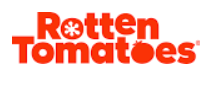

In this Notebook we are going to enrich the [Netflix Movies and TV Shows](https://www.kaggle.com/shivamb/netflix-shows) dataset provided by Shivam Bansai, by including additional information and customer / critics ratings from [Rotten Tomatoes](http://https://www.rottentomatoes.com/).

Rotten Tomatoes is an American review-aggregation website for movies and television shows. The enriching data has been mined by scraping web pages from Rotten Tomateos with Python and the BeautifulSoup package.

The following columns were added to the original Movies and TV Shows dataset:

* Movies

    1. **rottentomatoes_info**: additional information for the movie, including Genre, Director, Original Language, Producer, Writer, Release Date, Run Time, Production Co., etc. - *dict*
    2. **rottentomatoes_cast**: cast of the movie including role, first and last name of the actor/actress - *dict*
    3. **rottentomatoes_audience_score**: the score given to the movie by Rotten Tomatoes, based on the audience rating (0% to 100%) - *float64*
    4. **rottentomatoes_audience_#reviews**: the number of reviews given by the audience to the movies - *float64*
    5. **rottentomatoes_tomatometer_score**: the score given to the movie by Rotten Tomatoes, based on the critics rating (0% to 100%) - *float64* 
    6. **rottentomatoes_critics_#reviews**: the number of reviews given by critics to the movies - *float64*
    7. **rottentomatoes_critic_review**: some of the review written by critics, including review, date, critic's name, network - *list of dicts*
    
    
* TV Shows (split by seasons)

    1. **rottentomatoes_info**: additional information for the TV Show's season, including Genre, Director, Original Language, Producer, Writer, Release Date, Run Time, Production Co., etc. - *dict*
    2. **rottentomatoes_cast**: cast of the TV Show's season including role, first and last name of the actor/actress - *dict*
    3. **rottentomatoes_audience_score**: the score given to the season by Rotten Tomatoes, based on the audience rating (0% to 100%)- *float64*
    4. **rottentomatoes_audience_#reviews**: the number of reviews given by the audience to the season - *float64*
    5. **rottentomatoes_audience_review**: some of the review written by the audience, including comment, date and username - *list of dicts*
    6. **rottentomatoes_tomatometer_score**: the score given to the movie by Rotten Tomatoes, based on the critics rating (0% to 100%) - *float64*
    7. **rottentomatoes_critics_#reviews**: the number of reviews given by critics to the movies - *float64*
    8. **rottentomatoes_critic_review**: some of the review written by critics, including review, date, critic's name, network - *list of dicts*



## Preparation  

### Installing and importing packages

We will start by installing and importing the necessary libraries. Beside pandas and nunpy, **bs4** will be used for web scraping; **request** to access the web page; **re** for scripting using regex formatting

In [ ]:
!pip install bs4

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import requests
import re

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Uploading and show original dataset

In [ ]:
df = pd.read_csv('/kaggle/input/netflix-shows/netflix_titles.csv', index_col = 0)
df.tail()

To scrape pages from Rotten Tomatoes we need to separate TV shows from Movies, as they belong to different folders in the HTML structure (https://www.rottentomatoes.com/tv/* vs. https://www.rottentomatoes.com/m/*, respectively).

In [ ]:
# Split in movies and shows
df_movie = df[df.type == 'Movie']
df_shows = df[df.type == 'TV Show']

## Scraping Movies data from Rotten Tomatoes

The idea is to iterate over the df_movie dataset and recreate the schematic URL from Rotten Tomatoes, i.e. 

https://www.rottentomatoes.com/m/{name}

name should be in lower caps and with special characters taken off. Also spaces are replaced with _ . When a movie's title is not found, the request goes redirected to a generic 404 page -> the page contains no useful information, therefore it can be handled just by bypassing the current iteration in the for loop and return NaN values for the dataset.. 

Inspect the a sample Movies page to get the proper classes and attributes.


### **Warning:** the code below below will take hours to complete. I recommend to NOT run it while you are reading through this Notebook,but only use for reference. Why? 1) will take you too long and 2) Rotten Tomatoes will not be happy receving thousand of requests for scraping. I save you time by providing you directly the dataframe out of the script -> df_movies_with_tomatoscores_1-1_final.csv

    for i,idx in enumerate(df_movie.index):
        name = re.sub(r'[^A-Za-z0-9 ]+', '', df.loc[idx]['title']).replace(' ','_').lower() #

        typ = 'm'
        URL = f'https://www.rottentomatoes.com/{typ}/{name}/'
        print(URL)

        page = requests.get(URL)

        soup = BeautifulSoup(page.content, 'html.parser')

        if df.loc[show_id]['type']=='Movie':
            section = soup.find(id='topSection')
            if section == None: # Error handling for titles that cannot be found     
                print('Could not scrap from this movie: {}'.format(df.loc[idx]['title']))
                print(f'Progress: {round(i/len(df_movie)*100,2)}%')
                continue
            rat_percentage = section.find('score-board')
            df_movie.loc[idx,'rottentomatoes_audience_score'] = rat_percentage.attrs.get("audiencescore")
            df_movie.loc[idx,'rottentomatoes_tomatometer_score'] = rat_percentage.attrs.get("tomatometerscore")
            df_movie.loc[idx,'rottentomatoes_audience_#reviews'] = section.find_all('a', class_='scoreboard__link scoreboard__link--audience')
            df_movie.loc[idx,'rottentomatoes_critics_#reviews'] = section.find_all('a', class_='scoreboard__link scoreboard__link--tomatometer')
            print(df_movie.loc[idx,['rottentomatoes_audience_score','rottentomatoes_tomatometer_score','rottentomatoes_audience_#reviews','rottentomatoes_critics_#reviews']])
            print(f'Progress: {round(i/len(df_movie)*100,2)}%')

In [ ]:
df_movie_enr = pd.read_csv("/kaggle/input/netflix-movies-enriched/df_movies_with_tomatoscores_1-1_final.csv",index_col=0)
df_movie_enr.head()

In [ ]:
df_movie_enr.columns

In [ ]:
df_movie_enr.info()

We were able to augment more than 3200 movies out of the total 5377 (ca. 60%). Of those, a good portion appears to be lacking of enough reviews to have the scoring metrics. 

Let's have a closer look at the new columns

In [ ]:
for i in ['rottentomatoes_audience_score', 'rottentomatoes_tomatometer_score', 'rottentomatoes_audience_#reviews', 'rottentomatoes_critics_#reviews',
          'rottentomatoes_info', 'rottentomatoes_cast',
       'rottentomatoes_critic_review']:
    print(f'{i}: {df_movie_enr[i].iloc[0]}')

The outputs of certain columns are quite a mess, full of spaces, new lines and other character. That is how were scraped from the HTML document. Plus we need to convert most strings in our desired, easily accessible data type (e.g. dictionaries). Let's do a bit of data wrangling.

First, let's convert **rottentomatoes_audience_#reviews** in actual numbers. What values are currently present in the dataframe?

In [ ]:
df_movie_enr['rottentomatoes_audience_#reviews'].unique()

Ok then, we shall convert from string to the median values of the bins given by Rotten Tomatoes

In [ ]:
audience_rev_dict = {"[' Ratings']":0,
                    "['Fewer than 50 Ratings']":10,
                    "['50+ Ratings']":75,
                    "['100+ Ratings']":175,
                    "['250+ Ratings']":750,
                    "['1,000+ Ratings']":1750,
                    "['2,500+ Ratings']":7500,
                    "['10,000+ Ratings']":17500,
                    "['25,000+ Ratings']":32000,
                    "['50,000+ Ratings']":75000,
                    "['100,000+ Ratings']":175000,
                    "['250,000+ Ratings']":250000}


df_movie_enr['rottentomatoes_audience_#reviews'] = df_movie_enr['rottentomatoes_audience_#reviews'].replace(audience_rev_dict)

In [ ]:
df_movie_enr['rottentomatoes_audience_#reviews']

In [ ]:
print(df_movie_enr['rottentomatoes_audience_#reviews'].iloc[0])
print(type(df_movie_enr['rottentomatoes_audience_#reviews'].iloc[0]))

Same goes for the # of reviews from critics. To apply the changes of the values we need first to exclude all NaN values (those are the movies that either we could not scrap or have no info available). For example:

In [ ]:
print(df_movie_enr['rottentomatoes_critics_#reviews'].iloc[0])
print(type(df_movie_enr['rottentomatoes_critics_#reviews'].iloc[0]))

Let's convert this in number

In [ ]:
no_null = df_movie_enr[df_movie_enr['rottentomatoes_critics_#reviews'].notnull()]

for idx in no_null.index:
    df_movie_enr.loc[idx,'rottentomatoes_critics_#reviews'] = int(df_movie_enr.loc[idx,'rottentomatoes_critics_#reviews'].replace("['",'').replace("']",'').split(' ')[0])

In [ ]:
print(df_movie_enr['rottentomatoes_critics_#reviews'].iloc[0])
print(type(df_movie_enr['rottentomatoes_critics_#reviews'].iloc[0]))

Time for the info section. How does it look like?

In [ ]:
df_movie_enr['rottentomatoes_info'].iloc[0]

We need to eliminate all blank spaces and new lines (*\n*), then split the string by the semi-column character (separator of the different info classes) and create a dict out of it. 

In [ ]:
no_null = df_movie_enr[df_movie_enr['rottentomatoes_info'].notnull()]

for idx in no_null.index:
    df_movie_enr.loc[idx,'rottentomatoes_info'] = [{i[0]:i[1] for i in[x.split(':') for x in df_movie_enr.loc[idx,'rottentomatoes_info'].replace('\n','').replace('  ','').split(';')]}]

In [ ]:
df_movie_enr['rottentomatoes_info'].iloc[0]

Same goes with the cast section. Role name as key of the dict, the actor/actress name as dict values. This section present sometimes also other names like for the Screenwriter, Film Editor, Director, etc. 

In [ ]:
no_null = df_movie_enr[df_movie_enr['rottentomatoes_cast'].notnull()]

for idx in no_null.index:
    str_list = [el.split('\n') for el in df_movie_enr.loc[idx,'rottentomatoes_cast'].replace('  ','').split(';')]
    str_list = list(filter(lambda x: len(x)>1,[list(filter(None,el)) for el in str_list]))
    df_movie_enr.loc[idx,'rottentomatoes_cast'] = [{i[1]:i[0] for i in str_list}]

In [ ]:
df_movie_enr['rottentomatoes_cast'].iloc[0]

Next, the critic review section. Who is going to be the harshest of all critics?

In [ ]:
df_movie_enr['rottentomatoes_critic_review'].iloc[0]

For the critic review section we need to be a bit more creative, as sometimes they show all 5 info (Review, Date, Rating, Critic, Network) and sometimes only Review, Date, Network plus either or neither of Rating and Critic name. We will handle it with a helper function

In [ ]:
def create_dict(x):
    keys = ['Review','Date','Rating','Critic','Network']
    
    if len(x)==4:
        if 'Rating:' in x:
            keys.pop(3)
        else:
            keys.pop(2)
    elif len(x)==3:
        keys.pop(2)
        keys.pop(2)
        
    return dict(zip(keys,x))

In [ ]:
no_null = df_movie_enr[df_movie_enr['rottentomatoes_critic_review'].notnull()]

for idx in no_null.index:
    str_list = [el.split('\n') for el in df_movie_enr.loc[idx,'rottentomatoes_critic_review'].replace('  ','').replace('| ','').replace('Full Review…','').split(';')]
    str_list = list(filter(lambda x: len(x)>1,[list(filter(None,el)) for el in str_list]))
    df_movie_enr.at[idx,'rottentomatoes_critic_review'] = list(map(create_dict,str_list))

In [ ]:
df_movie_enr['rottentomatoes_critic_review'].iloc[0]

**The movie partition is ready to go!** Next up is the TV shows section

## Scraping TV Shows data from Rotten Tomatoes

The idea is to multiple the row of each TV show by the number of seasons present in the dataset, then iterate over the df_shows dataset and recreate the schematic URL from Rotten Tomatoes, i.e. 

https://www.rottentomatoes.com/tv/{name}/{sXY}

name should be in lower caps and with special characters taken off. Also spaces are replaced with _ . XY is the 2-digit season number. When a show's title is not found, the request goes redirected to a generic 404 page -> the page contains no useful information, therefore it can be handled just by bypassing the current iteration in the for loop and return NaN values for the dataset. 


Inspect the a sample TV Show page to get the proper classes and attributes.

In [ ]:
df_shows = df[df.type == 'TV Show'].copy().reset_index()
df_shows['season'] = df_shows['duration'].apply(lambda x: list(range(1,int(x.split(' ')[0])+1)))
df_shows = df_shows.explode('season', ignore_index=True)

### **Warning:** the code below below will take hours to complete. I recommend to NOT run it while you are reading through this Notebook,but only use for reference. Why? 1) will take you too long and 2) Rotten Tomatoes will not be happy receving thousand of requests for scraping. I save you time by providing you directly the dataframe out of the script -> df_shows_with_tomatoscores_1-1_final.csv

    df_shows.set_index(['show_id', 'season'], inplace=True)

    typ = 'tv'

    for i,idx in enumerate(df_shows.index):
        print(idx)
        name = re.sub(r'[^A-Za-z0-9 ]+', '', df_shows.loc[idx]['title']).replace(' ','_').lower()
        s = 's'+'{:02d}'.format(idx[1])

        URL = f'https://www.rottentomatoes.com/{typ}/{name}/{s}'
        print(URL)
        page = requests.get(URL)

        soup = BeautifulSoup(page.content, 'html.parser')

        # Rating Section
        topSection = soup.find(id='topSection')
        if topSection == None:
            print('Could not scrap from this movie: {}'.format(df_shows.loc[idx]['title']))
            print(f'Progress: {round(i/len(df_shows)*100,2)}%')
            continue


        # Score Sections 
        tomatometerSection = topSection.find_all('div', class_="mop-ratings-wrap__half critic-score")
        try:
            pre_filt_list = tomatometerSection[0].text.replace('\n','').split('  ')
            filt_list = list(filter(lambda x: x!='', pre_filt_list)) # Filter out empty string item in the list 
        except:
            print('Could not scrap from this movie: {}'.format(df_shows.loc[idx]['title']))
            print(f'Progress: {round(i/len(df_shows)*100,2)}%')
            continue
        df_shows.loc[idx,'rottentomatoes_tomatometer_score'] = filt_list[0]
        df_shows.loc[idx,'rottentomatoes_critics_#reviews'] = filt_list[-1]

        audienceSection = topSection.find_all('div', class_='mop-ratings-wrap__half audience-score')
        pre_filt_list = audienceSection[0].text.replace('\n','').split('  ')
        filt_list = list(filter(lambda x: x!='', pre_filt_list)) # Filter out empty string item in the list

        df_shows.loc[idx,'rottentomatoes_audience_score'] = filt_list[0]
        df_shows.loc[idx,'rottentomatoes_audience_#reviews'] = filt_list[-1].split(':')[-1]

        # TV Season Info Section
        infoSection = soup.find('section', class_='panel panel-rt panel-box movie_info')
        media_info = infoSection.find_all('li', class_='meta-row clearfix')
        df_shows.loc[idx,'rottentomatoes_info'] =';'.join([el.text for el in media_info])

        # Cast & Crew 
        castSection = soup.find(id='tv-series-cast')
        if castSection:
            print('yeah')
            cast_info = castSection.find_all('div', class_='media-body')
            df_shows.loc[idx,'rottentomatoes_cast'] = ';'.join([el.text for el in cast_info])


In [ ]:
df_shows_enr = pd.read_csv("/kaggle/./input/netflix-movies-enriched/df_shows_with_tomatoscores_v1-1_final.csv")
df_shows_enr.head()

The dataframe is reindexed to avoid handling MultiIndexing, not really needed at this stage. 

In [ ]:
df_shows_enr.columns

In [ ]:
df_shows_enr.info()

We could scrap around 2389 seasons out of 4280 (ca. 56%). Of those, a good portion appears to be lacking of cast information and critic / audience comments / reviews. 

Let's have a closer look at the new columns

In [ ]:
for i in ['rottentomatoes_audience_score', 'rottentomatoes_tomatometer_score', 'rottentomatoes_audience_#reviews', 'rottentomatoes_critics_#reviews',
          'rottentomatoes_info', 'rottentomatoes_cast',
       'rottentomatoes_critic_review']:
    print(f'{i}: {df_shows_enr[i].iloc[10]}')

Similar mess as with the Movie Case. But we can fix it!

Let's start with the **rottentomatoes_tomatometer_score** column. We need to replace the nasty strings into numbers

In [ ]:
print(df_shows_enr['rottentomatoes_tomatometer_score'].unique())
print(type(df_shows_enr['rottentomatoes_tomatometer_score'].iloc[10]))

In [ ]:
df_shows_enr['rottentomatoes_tomatometer_score'] = df_shows_enr['rottentomatoes_tomatometer_score'].replace({'Not enough ratings to calculate a score.':0})
df_shows_enr['rottentomatoes_tomatometer_score'] = df_shows_enr['rottentomatoes_tomatometer_score'].apply(lambda x: str(x).replace('%',''))
df_shows_enr['rottentomatoes_tomatometer_score'] = df_shows_enr['rottentomatoes_tomatometer_score'].replace('nan',np.nan).replace('',np.nan).astype(float)

In [ ]:
df_shows_enr['rottentomatoes_tomatometer_score'].unique()

Next is **rottentomatoes_tomatometer_score**. Let's convert strings in numbers and eliminate strange values

In [ ]:
print(df_shows_enr['rottentomatoes_critics_#reviews'].unique())
print(type(df_shows_enr['rottentomatoes_critics_#reviews'].iloc[10]))

In [ ]:
df_shows_enr['rottentomatoes_critics_#reviews'] = df_shows_enr['rottentomatoes_critics_#reviews'].replace({'Critic Ratings: ':np.nan}).astype(float)

In [ ]:
print(df_shows_enr['rottentomatoes_critics_#reviews'].unique())
print(type(df_shows_enr['rottentomatoes_critics_#reviews'].iloc[10]))

In [ ]:
print(df_shows_enr['rottentomatoes_audience_score'].iloc[10])
print(type(df_shows_enr['rottentomatoes_audience_score'].iloc[10]))

In [ ]:
df_shows_enr['rottentomatoes_audience_score'] = df_shows_enr['rottentomatoes_audience_score'].replace({'No Score YetAudience Score':0})
df_shows_enr['rottentomatoes_audience_score'] = df_shows_enr['rottentomatoes_audience_score'].apply(lambda x: str(x).replace('%',''))
df_shows_enr['rottentomatoes_audience_score'] = df_shows_enr['rottentomatoes_audience_score'].replace('nan',np.nan).replace('',np.nan).astype(float)

In [ ]:
print(df_shows_enr['rottentomatoes_audience_score'].iloc[10])
print(type(df_shows_enr['rottentomatoes_audience_score'].iloc[10]))

Now we repeat the passages done in the Movies section for the last columns. The audience review column is unique for the TV Shows dataframe, but it is handled like the critic review column.

In [ ]:
print(df_shows_enr['rottentomatoes_info'].iloc[10])

In [ ]:
no_null = df_shows_enr[df_shows_enr['rottentomatoes_info'].notnull()]
for idx in no_null.index:
    df_shows_enr.loc[idx,'rottentomatoes_info'] = [{i[0]:i[1] for i in[x.split(':') for x in df_shows_enr.loc[idx,'rottentomatoes_info'].replace(');','),').replace('\n','').replace('  ','').split(';')]}]

In [ ]:
print(df_shows_enr['rottentomatoes_info'].iloc[10])

In [ ]:
print(df_shows_enr['rottentomatoes_cast'].iloc[11])

In [ ]:
no_null = df_shows_enr[df_shows_enr['rottentomatoes_cast'].notnull()]

for idx in no_null.index:
    str_list = [el.split('\n') for el in df_shows_enr.loc[idx,'rottentomatoes_cast'].replace('  ','').split(';')]
    str_list = list(filter(lambda x: len(x)>1,[list(filter(None,el)) for el in str_list]))
    df_shows_enr.loc[idx,'rottentomatoes_cast'] = [{i[1]:i[0] for i in str_list}]

In [ ]:
print(df_shows_enr['rottentomatoes_cast'].iloc[11])

In [ ]:
print(df_shows_enr['rottentomatoes_critic_review'].iloc[11])

In [ ]:
no_null = df_shows_enr[df_shows_enr['rottentomatoes_critic_review'].notnull()]

for idx in no_null.index:
    str_list = [el.split('\n') for el in df_shows_enr.loc[idx,'rottentomatoes_critic_review'].replace('Full Review…\n\n;','').replace('  ','').replace('| ','').replace('|','').split(';')]
    str_list = list(filter(lambda x: len(x)>1,[list(filter(None,el)) for el in str_list]))
    df_shows_enr.at[idx,'rottentomatoes_critic_review'] = list(map(create_dict,str_list))

In [ ]:
print(df_shows_enr['rottentomatoes_critic_review'].iloc[11])

Last column with the **rottentomatoes_audience_review**. Here we just have three data points: Date, Review and User Name

In [ ]:
def create_dict_audience(x):
    keys = ['Date','Review','User Name']        
    return dict(zip(keys,x))

In [ ]:
no_null = df_shows_enr[df_shows_enr['rottentomatoes_audience_review'].notnull()]

for idx in no_null.index:
    str_list = [el.split('\n') for el in df_shows_enr.loc[idx,'rottentomatoes_audience_review'].split(';')]
    str_list = list(filter(lambda x: len(x)>1,[list(filter(None,el)) for el in str_list]))
    for item in str_list:
        if len(item)==2:
            item.append('Anonym')
    df_shows_enr.at[idx,'rottentomatoes_audience_review'] = list(map(create_dict_audience,str_list))

In [ ]:
df_shows_enr['rottentomatoes_audience_review'].iloc[11]

## Merging Dataframes and save outputs

It's time to reunite the two dataframes. This time we have to add an extra dimension to the dataset, as the season part of the TV shows were not broken down. To handle this particular settings, we need to define MultiIndex in pandas.

In [ ]:
df_shows_enr.index = pd.MultiIndex.from_frame(df_shows_enr[['show_id','season']])

In [ ]:
netflix_movies_enriched = pd.concat([df_movie_enr, df_shows_enr])

In [ ]:
netflix_movies_enriched

Let's give the new dataframe a new column order, inspect and save our progress

In [ ]:
new_order = ['cast',
 'type',
 'show_id',
 'season',
 'title',
 'country',
 'date_added',
 'release_year',
 'description',
 'director',
 'duration',
 'listed_in',
 'rating',
 'rottentomatoes_info', 
 'rottentomatoes_cast',
 'rottentomatoes_audience_score',
 'rottentomatoes_audience_#reviews',
 'rottentomatoes_audience_review',
 'rottentomatoes_tomatometer_score',
 'rottentomatoes_critics_#reviews',
 'rottentomatoes_critic_review',
 ]

netflix_movies_enriched = netflix_movies_enriched[new_order]
netflix_movies_enriched = netflix_movies_enriched.drop(['show_id','season'], axis=1)

In [ ]:
netflix_movies_enriched.info()

In [ ]:
netflix_movies_enriched.to_csv('/kaggle/working/netflix_titles_enriched.csv')

## Done!

We have now a fresh new dataset, enriched with valuable data from Rotten Tomatoes. The fresh newly backed data can now be used to augment the analysis of the original Netflix movies and tv shows datset. Some inspiration for its uses: 

- Compare scores against other attributed (genres, 
- Fill in missing information from original dataset
- Analyse how TV shows develops in terms of rating and reviews as new seasons are released
- Sentiment analysis of Movies based on Critics Reviews
- Integration of iMDB ratings to correlate with Rotten Tomatoes

etc.

Have fun!